In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.utils import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from model.SE_DenseNet import SE_DenseNet121, SE_DenseNet121_Multi, multi_cnn_se_densenet

2023-07-08 12:21:09.349428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 12:21:15.976929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-08 12:21:15.976999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-07-08 12:21:15.977006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

#### Using weights

In [2]:
# Init hyperparameters
epoch= 30
batch_size= 64
input_shape= (128, 128, 3)
using_class_weight= False
num_classes= 5

In [3]:
model= multi_cnn_se_densenet(input_shape= input_shape, num_classes=num_classes)

In [4]:
model.load_weights("/media/data3/users/longnd/ML_prj/checkpoints/se_densenet121.h5")

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 head_conv (Conv2D)             (None, 64, 64, 192)  28416       ['input[0][0]']                  
                                                                                                  
 head_bn (BatchNormalization)   (None, 64, 64, 192)  768         ['head_conv[0][0]']              
                                                                                                  
 head_relu (Activation)         (None, 64, 64, 192)  0           ['head_bn[0][0]']            

In [10]:
# load data
train_data, test_data= get_data('/media/data3/users/longnd/ML_prj/Data', input_shape, batch_size)

model_path = "/media/data3/users/longnd/ML_prj/checkpoints/multi_se_densenet.h5"
checkpoint = ModelCheckpoint(filepath= model_path,
                            save_weights_only= True,
                            monitor= 'val_accuracy',
                            save_best_only= True, verbose=1)

earlystop = EarlyStopping(monitor= 'val_accuracy', 
                          min_delta= 0.01, 
                          patience= 15,
                          verbose= 1,
                          restore_best_weights= True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

Found 10639 validated image filenames belonging to 5 classes.
Found 2662 validated image filenames belonging to 5 classes.


In [7]:
model_compiling(model)

In [11]:
# train model
class_weight= get_balanced_weight(train_data)
if using_class_weight:
    print(class_weight)
    history = model.fit(
        train_data, 
        validation_data= test_data, 
        epochs=epoch, 
        class_weight=class_weight,
        callbacks=[earlystop, checkpoint, learning_rate_reduction])
else:
    history = model.fit(
        train_data, 
        validation_data= test_data, 
        epochs=epoch, 
        callbacks=[earlystop, checkpoint, learning_rate_reduction])

Epoch 1/30
167/167 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.9107 - precision: 0.9197 - recall: 0.9014 - f1_score: 0.9105
Epoch 1: val_accuracy improved from -inf to 0.45379, saving model to /media/data3/users/longnd/ML_prj/checkpoints/multi_se_densenet.h5
167/167 [==============================] - 203s 1s/step - loss: 0.3560 - accuracy: 0.9107 - precision: 0.9197 - recall: 0.9014 - f1_score: 0.9105 - val_loss: 2.4623 - val_accuracy: 0.4538 - val_precision: 0.4580 - val_recall: 0.4403 - val_f1_score: 0.4490 - lr: 0.0010
Epoch 2/30
167/167 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.9129 - precision: 0.9216 - recall: 0.9032 - f1_score: 0.9123
Epoch 2: val_accuracy improved from 0.45379 to 0.82645, saving model to /media/data3/users/longnd/ML_prj/checkpoints/multi_se_densenet.h5
167/167 [==============================] - 220s 1s/step - loss: 0.3429 - accuracy: 0.9129 - precision: 0.9216 - recall: 0.9032 - f1_score: 0.9123 - val_lo

In [12]:
# save history
save_history_to_csv(history, 'se_densenet121.csv')

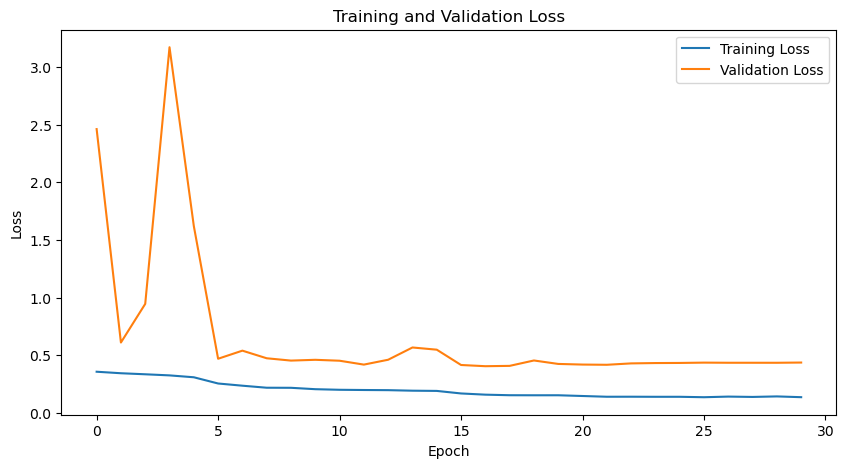

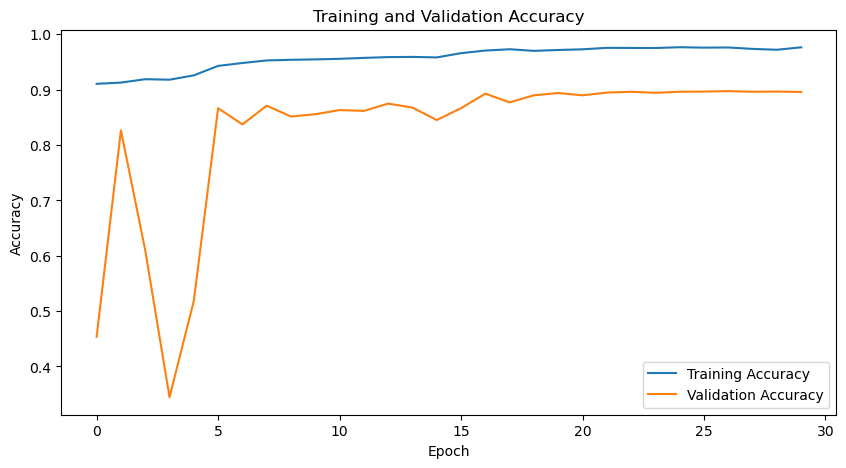

In [13]:
# plot history
plot_history(history)

In [14]:
# print result
get_report(model, test_data)

42/42 [==============================] - 18s 257ms/step
              precision    recall  f1-score   support

     COVID19       0.87      0.84      0.85       116
     NORMAL1       0.85      0.92      0.88      1017
   PNEUMONIA       0.98      0.97      0.98       855
TUBERCULOSIS       1.00      0.97      0.99       140
PNEUMOTHORAX       0.83      0.73      0.78       534

    accuracy                           0.90      2662
   macro avg       0.91      0.89      0.89      2662
weighted avg       0.90      0.90      0.90      2662



#### Using GAN